In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances

import os, sys

cwd = os.getcwd()
frameworkDir = os.path.abspath(os.path.join(cwd, os.pardir, 'src'))
sys.path.append(frameworkDir)

from dackar.utils.num import t_score

np.random.seed(6)

In [2]:
def generateSeries(maxT, t1, t2, tsql, sqlDur):
    N  = 5000
    N_spk = 7

    cpu        = np.zeros(N)
    t          = np.linspace(0,maxT,N)
    noise_base = np.random.normal(0,0.005,N)

    spikesLoc = np.random.randint(low=0, high=N, size=N_spk)
    spikesDT  = np.random.randint(low=10, high=20, size=N_spk)
    
    difference_array_1 = np.absolute(t-t1)
    index1 = difference_array_1.argmin()

    difference_array_2 = np.absolute(t-t2)
    index2 = difference_array_2.argmin()
    
    cpu[0:index1] = .3
    cpu[index2:N] = .3
    cpu[index1:index2] = .9
    cpu = cpu + noise_base
    
    # random spikes
    for i in range(N_spk):
        noise_spike = np.absolute(np.random.normal(0,0.04, spikesDT[i]))
        for dt in range(spikesDT[i]):
            cpu[spikesLoc[i] + dt] = cpu[spikesLoc[i] + dt] + noise_spike[dt]
            
    # SQL spikes
    noiseSQL = np.absolute(np.random.normal(0,0.08, sqlDur))
    for dt in range(sqlDur):
        cpu[tsql + dt] = cpu[tsql + dt] + noiseSQL[dt]

    print('Anomaly ratio: total', (index2-index1 + np.sum(spikesDT[i]))/N)
    print('Anomaly ratio: large spikes:', (index2-index1)/N)
    print('Anomaly ratio: small spikes', (np.sum(spikesDT[i]))/N)
        
    return t,cpu

In [3]:
maxT = 1000
t1 = 300
t2 = 370
tsql   = 650
sqlDur = 50
t, cpu = generateSeries(maxT, t1, t2, tsql, sqlDur)

difference_array_1 = np.absolute(t-t1)
loc1 = difference_array_1.argmin()
difference_array_2 = np.absolute(t-t2)
loc2 = difference_array_2.argmin()

# True negative
E1_loc = loc1 - 10
E2_loc = loc1 + 10
E3_loc = loc2 - 10
E4_loc = loc2 + 10
E5_loc = loc1 + 35

# True positive
EA = 900
difference_array_0 = np.absolute(t-EA)
EA_loc = difference_array_0.argmin()

EB = 500
difference_array_0 = np.absolute(t-EB)
EB_loc = difference_array_0.argmin()

EC = 200
difference_array_0 = np.absolute(t-EC)
EC_loc = difference_array_0.argmin()

Anomaly ratio: total 0.0736
Anomaly ratio: large spikes: 0.07
Anomaly ratio: small spikes 0.0036


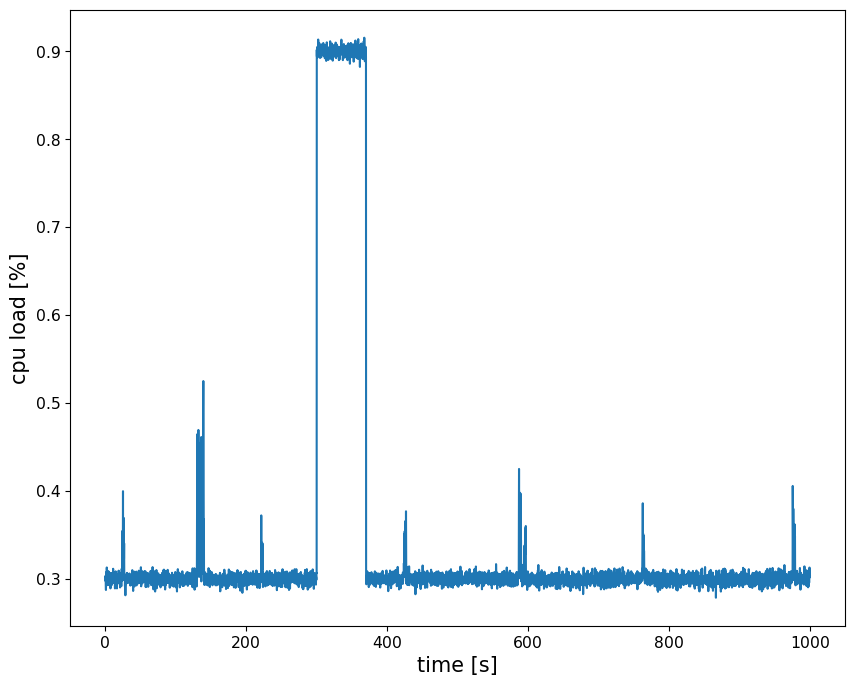

In [4]:
plt.close()
fig, ax = plt.subplots()
ax.plot(t,cpu)

plt.xlabel('time [s]')
plt.ylabel('cpu load [%]')
plt.show()

In [5]:
windowSize = 100
omegaSize = 500
alpha = 0.05
N_iterations = 100
alpha_value = 0.0736

# generate omega set
omegaSet = t_score.omega(windowSize,cpu,omegaSize)
L_front  = t_score.getL(E1_loc,windowSize,cpu,'front')
L_rear   = t_score.getL(E1_loc,windowSize,cpu,'rear')

Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.266
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.734, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events


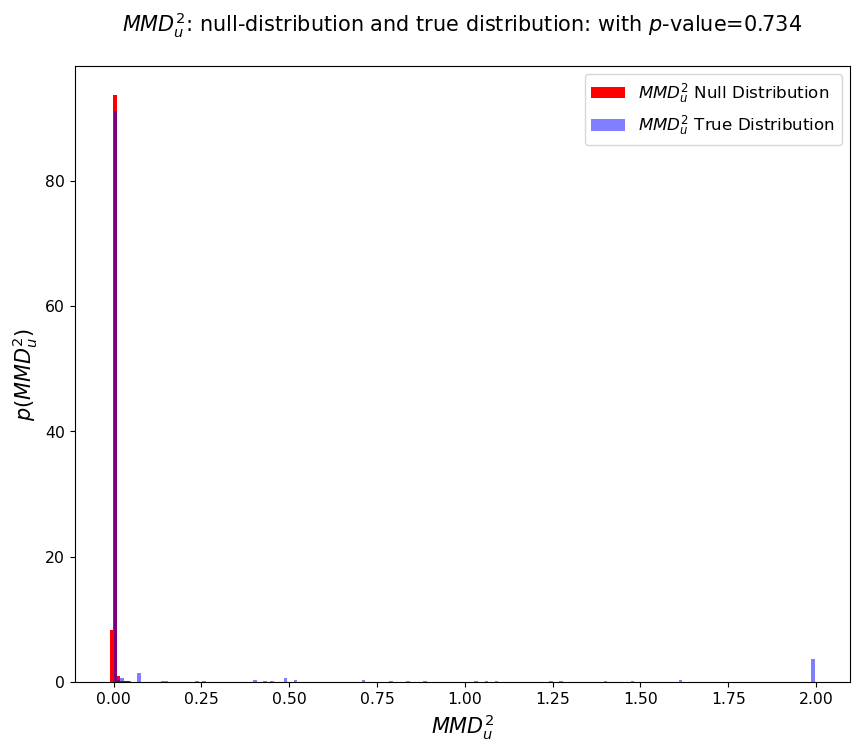

(0.734, False)

In [6]:
t_score.MMD_test(L_front,omegaSet,N_iterations,alpha,alpha_value,True)

Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.988
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.01200000000000001, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events


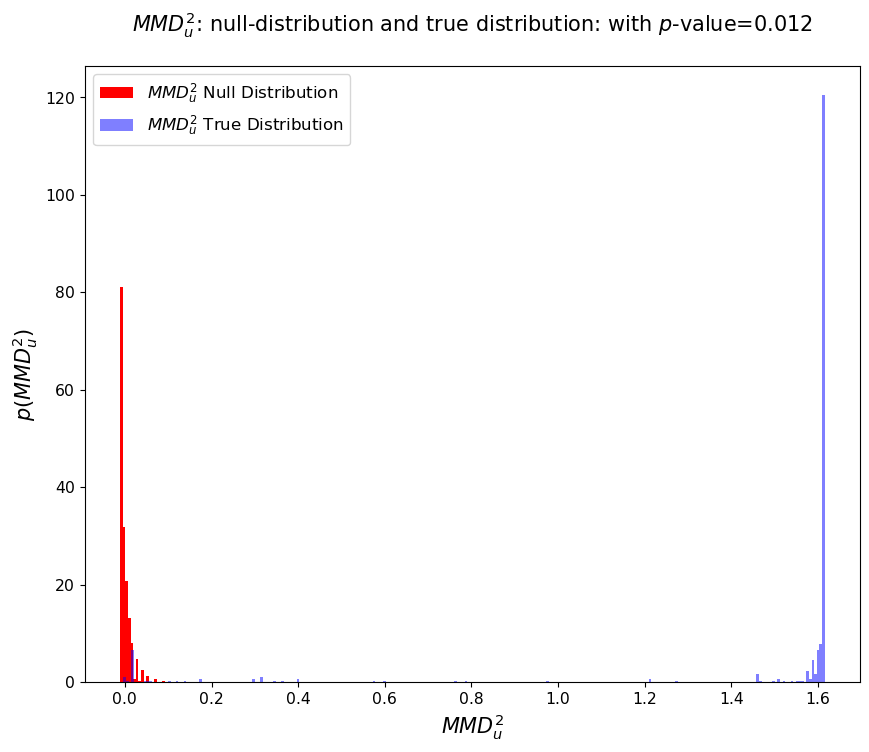

(0.01200000000000001, True)

In [7]:
t_score.MMD_test(L_rear,omegaSet,N_iterations,alpha,alpha_value,True)

Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.978
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.02200000000000002, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events


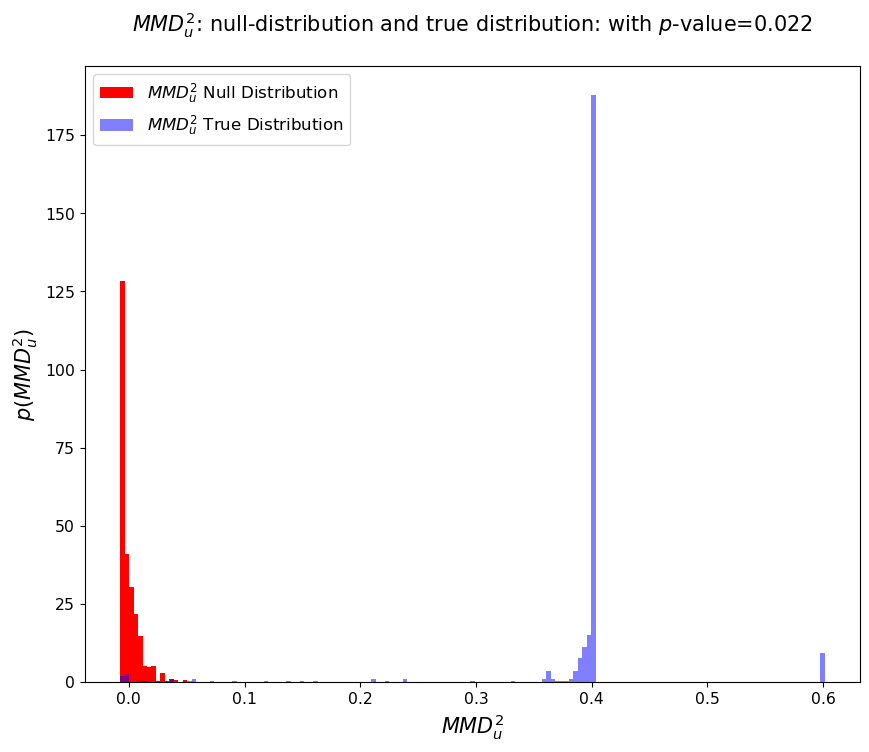

(0.02200000000000002, True)

In [8]:
L_front_rear = np.concatenate((L_front, L_rear), axis=None)
t_score.MMD_test(L_front_rear,omegaSet,N_iterations,alpha,alpha_value)

In [9]:
t_score.MMD_test(L_front,L_rear,N_iterations,alpha,alpha_value)

Null hypothesis: the two sub-series are generated from the same distribution
The p-value is: 0.01, which is less than the significant level: 0.05
The null hypothesis got rejected
The two sub-series are generated from two different distributions


(0.01, True)

In [10]:
t_score.event2TStest(E_loc=E1_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.268
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.732, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.732

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.996
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.0040000000000000036, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events
True

In [11]:
t_score.event2TStest(E_loc=E2_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.988
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.01200000000000001, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events
True 0.01200000000000001

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.948
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.052000000000000046, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to t

In [12]:
t_score.event2TStest(E_loc=E3_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.958
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.04200000000000004, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events
True 0.04200000000000004

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.994
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.006000000000000005, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to t

In [13]:
t_score.event2TStest(E_loc=E4_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.996
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.0040000000000000036, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events
True 0.0040000000000000036

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.242
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.758, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anom

In [14]:
t_score.event2TStest(E_loc=E5_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.992
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.008000000000000007, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to the anomaly events
True 0.008000000000000007

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.952
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.04800000000000004, which is smaller than given test value 0.0736
The null hypothesis got rejected
The sub-series is correlated to 

In [15]:
t_score.event2TStest(E_loc=EA_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.274
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.726, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.726

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.272
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.728, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.728

Com

In [16]:
t_score.event2TStest(E_loc=EB_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.266
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.734, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.734

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.278
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.722, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.722

Com

In [17]:
t_score.event2TStest(E_loc=EC_loc, TS=cpu, iterations=N_iterations, alphaTest=alpha, alphaOmegaset=alpha_value, windowSize=windowSize, omegaSize=omegaSize)

MMD Testing
Computing statitics for Lfront vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.294
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.706, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.706

Computing statitics for Lrear vs. omega
Number of rejection ratio for the null hypothesis in two sample testing for two given sub-series is: 0.288
Null hypothesis: the sub-series are generated from the normal conditions of full time-series
The probability of the sub-series are generated from the normal conditions of full time-series is 0.712, which is greater than given test value 0.0736
The null hypothesis got accepted
The sub-series is not correlated to the anomaly events
False 0.712

Com